In [1]:
# Install required packages (if running on Colab)
!pip install openpyxl scikit-learn seaborn --quiet

#  Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
file_path = '/content/Health_Insurance_Fraud.xlsx'
data = pd.read_excel(file_path, sheet_name='Fraud_Detection_decsion tree')


Data wrangling

In [3]:
# Clean column names
data.columns = data.columns.str.replace('-', '.').str.replace(' ', '_')


In [4]:
#  Replace '?' with NaN
data.replace('?', np.nan, inplace=True)

In [5]:
# Drop rows with missing values
data.dropna(inplace=True)

In [ ]:
# 🧹 Drop unnecessary columns
data.drop(['policy_number', 'policy_bind_date', 'insured_zip', 'incident_location'], axis=1, inplace=True)

In [7]:
from sklearn.preprocessing import LabelEncoder

cat_cols = data.select_dtypes(include='object').columns
label_encoders = {}

for col in cat_cols:
    data[col] = data[col].astype(str)  # Ensure all values are strings
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le


In [8]:
for col in cat_cols:
    unique_types = data[col].apply(type).unique()
    if len(unique_types) > 1:
        print(f"Column '{col}' has mixed types: {unique_types}")


In [9]:
# Encode categorical variables
cat_cols = data.select_dtypes(include='object').columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

📊 Exploratory Data Analysis

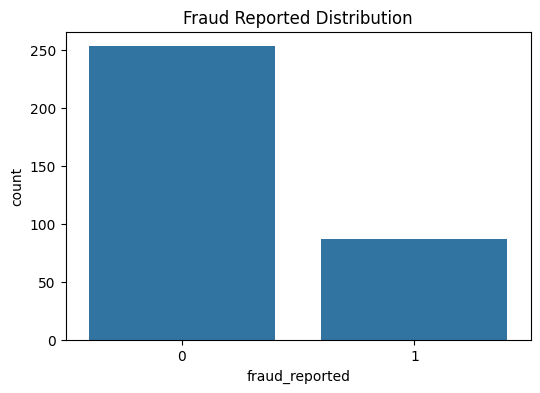

In [10]:
#  Exploratory Data Analysis
plt.figure(figsize=(6,4))
sns.countplot(x='fraud_reported', data=data)
plt.title("Fraud Reported Distribution")
plt.show()

#Insight:
This plot shows that a majority of the insurance claims in the dataset are non-fraudulent (N), but a significant proportion (around 25%) are reported as fraudulent (Y). This class imbalance needs to be kept in mind when modeling, as it may impact model sensitivity and specificity.


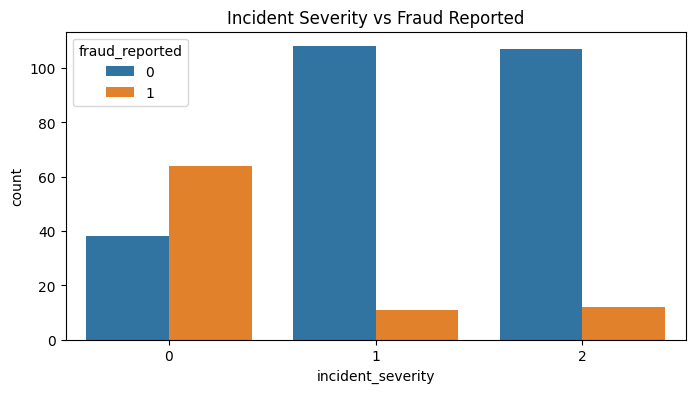

In [11]:
plt.figure(figsize=(8,4))
sns.countplot(x='incident_severity', hue='fraud_reported', data=data)
plt.title("Incident Severity vs Fraud Reported")
plt.show()

# Insight:
Claims involving "Major Damage" are more frequently reported as fraudulent compared to those with "Minor" or "Trivial" damage. This suggests that claim severity is a strong indicator of potential fraud, likely because larger claims present a higher opportunity for abuse.


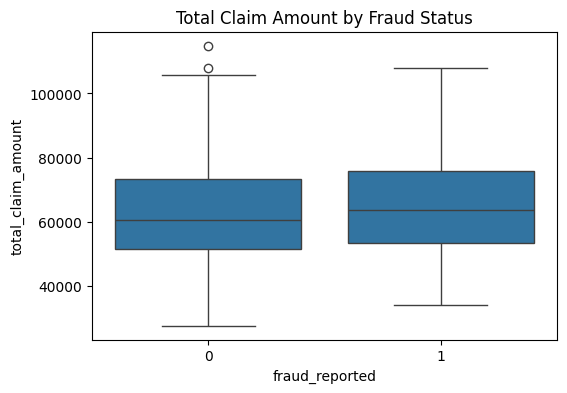

In [12]:
plt.figure(figsize=(6,4))
sns.boxplot(x='fraud_reported', y='total_claim_amount', data=data)
plt.title("Total Claim Amount by Fraud Status")
plt.show()

# Insight:
The boxplot reveals that fraudulent claims tend to have a wider range and higher median total claim amounts. This supports the intuition that fraudsters often inflate claim values to maximize gain, making this feature particularly valuable for prediction.

ML Modeling

In [16]:
# Drop datetime columns
datetime_cols = data.select_dtypes(include='datetime64[ns]').columns
data = data.drop(columns=datetime_cols)


In [17]:
#  Train-Test Split
X = data.drop('fraud_reported', axis=1)
y = data['fraud_reported']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [18]:
# Decision Tree Model
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91        80
           1       0.65      0.68      0.67        22

    accuracy                           0.85       102
   macro avg       0.78      0.79      0.79       102
weighted avg       0.86      0.85      0.85       102



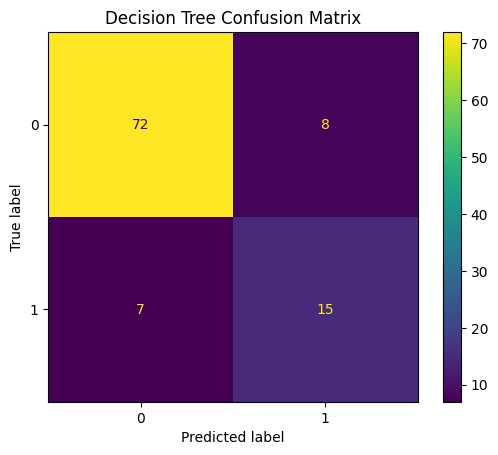

In [19]:
#  Evaluation - Decision Tree
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dt)).plot()
plt.title("Decision Tree Confusion Matrix")
plt.show()

In [20]:
#  Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87        80
           1       0.53      0.36      0.43        22

    accuracy                           0.79       102
   macro avg       0.69      0.64      0.65       102
weighted avg       0.77      0.79      0.78       102



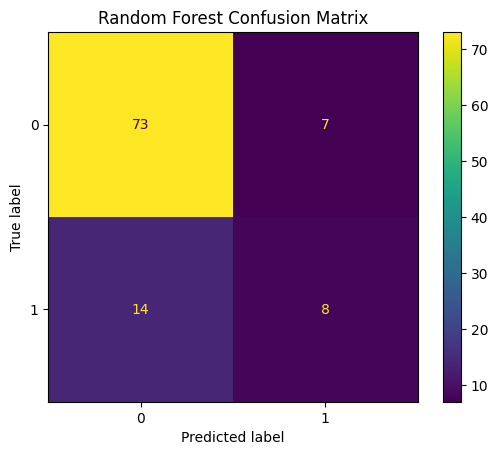

In [21]:
# Evaluation - Random Forest
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf)).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

<ipython-input-22-881e4a7ddb44>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, y='Feature', x='Importance', palette='Blues_r')


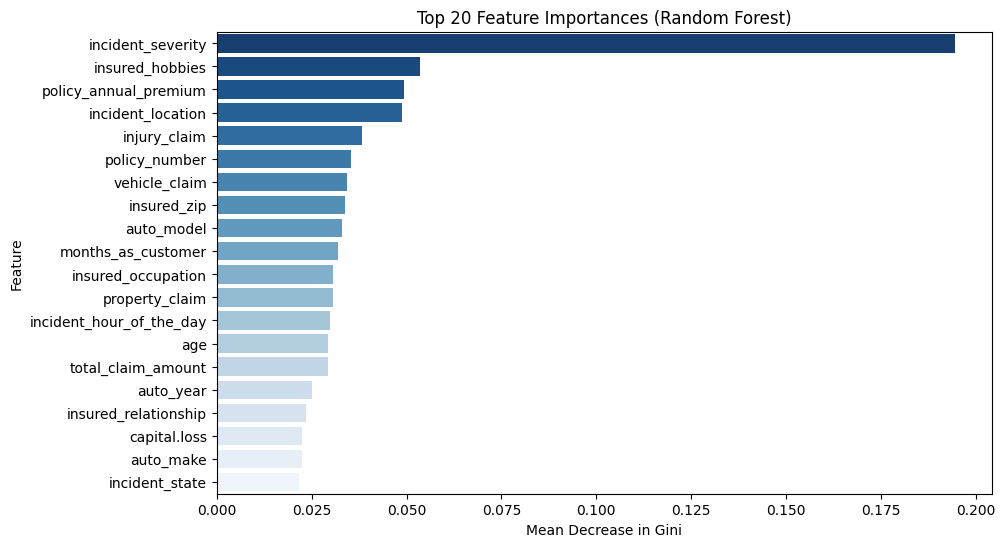

In [22]:
# Feature Importance Plot
importances = rf.feature_importances_
feat_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_df, y='Feature', x='Importance', palette='Blues_r')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Mean Decrease in Gini")
plt.show()

# Insight:
The random forest model identifies features like incident_severity, auto_model, auto_make, insured_hobbies, and property_claim as some of the most important for detecting fraud. These variables offer valuable behavioral and contextual cues, showing that not only financial metrics but also customer behavior patterns contribute to effective fraud detection.